In [13]:
# Imports
import librosa, librosa.display
import matplotlib.pyplot as plt
import os
import numpy as np
import math
import json
import cv2
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

In [14]:
# Load data
DATA_PATH = "json_storage/data.json"
IMG_SIZE = 48

def load_audio_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)
        
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

def load_image_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)
        
    X = np.array(data["image"]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    y = np.array(data["labels"])
    return X, y

In [15]:
# Split data
def prepare_datasets(validation_size, X, y, A_type):

    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=validation_size)

    if(A_type):
        X_train = X_train[..., np.newaxis]
        X_validation = X_validation[..., np.newaxis]
    
    return X_train, X_validation, y_train, y_validation

In [16]:
# CNN model
def build_model(input_shape):
    model = keras.Sequential()
    
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))                                
    model.add(keras.layers.Dropout(0.25))  
    
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))   
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))                                
    model.add(keras.layers.Dropout(0.25))
    
    model.add(keras.layers.Flatten())
        
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(480, activation='relu'))
    model.add(keras.layers.Dropout(0.05))
    
    model.add(keras.layers.Dense(3, activation='softmax'))
    
    return model

In [17]:
# Train/Test Split data
validation_size = 0.2

X_audio, y_audio = load_audio_data(DATA_PATH)
X_image, y_image = load_image_data(DATA_PATH)

X_audio_train, X_audio_validation, y_audio_train, y_audio_validation = prepare_datasets(validation_size, X_audio, y_audio, True)

X_image_train, X_image_validation, y_image_train, y_image_validation = prepare_datasets(validation_size, X_image, y_image, False)

In [18]:
# Audio train
audio_input_shape = (X_audio_train.shape[1], X_audio_train.shape[2], X_audio_train.shape[3])
audio_model = build_model(audio_input_shape)

audio_optimizer = keras.optimizers.Adam(learning_rate=0.0001)

audio_model.compile(optimizer=audio_optimizer,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

audio_model.summary()

audio_history = audio_model.fit(X_audio_train, y_audio_train, batch_size=2, epochs=40, validation_data=(X_audio_validation, y_audio_validation))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 85, 11, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 85, 11, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 83, 9, 32)         9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 83, 9, 32)         128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 5, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 42, 5, 32)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 42, 5, 32)         1

120/120 [==============================] - 1s 8ms/step - loss: 0.0267 - accuracy: 0.9917 - val_loss: 0.1045 - val_accuracy: 0.9667
Epoch 40/40
120/120 [==============================] - 1s 8ms/step - loss: 0.0157 - accuracy: 0.9958 - val_loss: 0.0498 - val_accuracy: 0.9667


In [20]:
# Image train
X_image_train = X_image_train.astype("float32")/255.0
X_image_validation = X_image_validation.astype("float32")/255.0

image_input_shape = (X_image_train.shape[1:])
image_model = build_model(image_input_shape)

image_optimizer = keras.optimizers.Adam(learning_rate=0.0001)

image_model.compile(optimizer=image_optimizer,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

image_model.summary()

image_history = image_model.fit(X_image_train, y_image_train, batch_size=2, epochs=40, validation_data=(X_image_validation, y_image_validation))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 46, 46, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 44, 44, 32)        9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 44, 44, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 22, 22, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 22, 22, 32)       

Epoch 39/40
120/120 [==============================] - 2s 17ms/step - loss: 0.2417 - accuracy: 0.9083 - val_loss: 0.3939 - val_accuracy: 0.8667
Epoch 40/40
120/120 [==============================] - 2s 17ms/step - loss: 0.1255 - accuracy: 0.9500 - val_loss: 0.1164 - val_accuracy: 0.9667


Text(0.5, 1.0, 'Image Accuracy Curves')

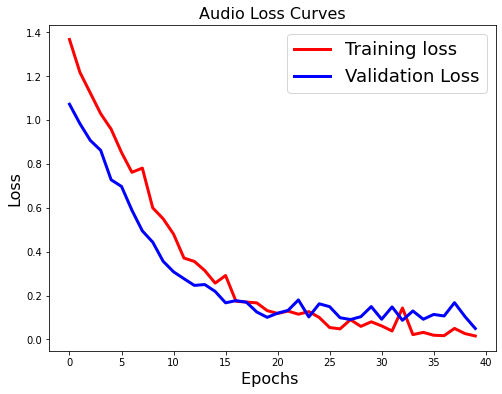

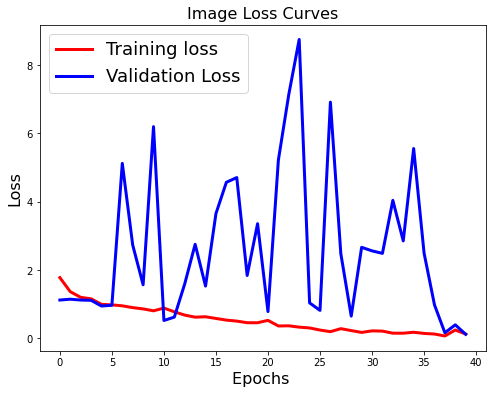

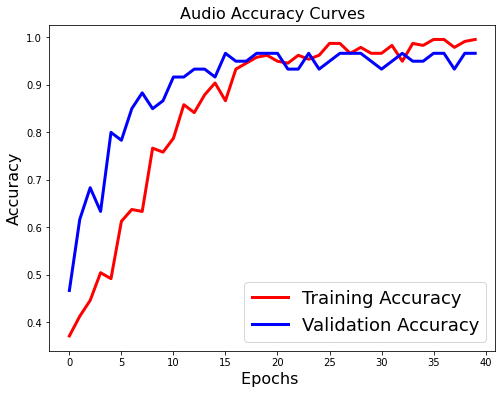

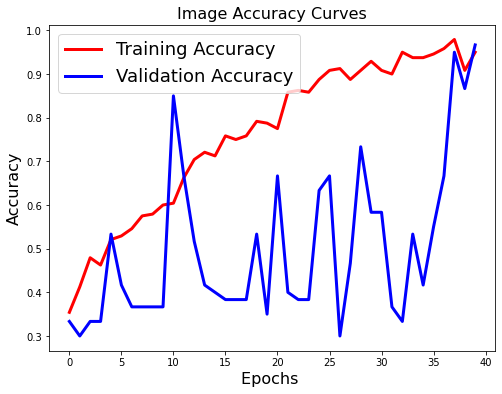

In [21]:
#Audio Loss Curves
plt.figure(figsize=[8,6])
plt.plot(audio_history.history['loss'],'r',linewidth=3.0)
plt.plot(audio_history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Audio Loss Curves',fontsize=16)

#Image Loss Curves
plt.figure(figsize=[8,6])
plt.plot(image_history.history['loss'],'r',linewidth=3.0)
plt.plot(image_history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Image Loss Curves',fontsize=16)

#Audio Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(audio_history.history['accuracy'],'r',linewidth=3.0)
plt.plot(audio_history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Audio Accuracy Curves',fontsize=16)

#Image Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(image_history.history['accuracy'],'r',linewidth=3.0)
plt.plot(image_history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Image Accuracy Curves',fontsize=16)

In [22]:
# Load test data
TEST_DATA_PATH = "json_storage/test.json"

X_audio, y_audio = load_audio_data(TEST_DATA_PATH)
X_image, y_image = load_image_data(TEST_DATA_PATH)

X_audio = X_audio[..., np.newaxis]
X_image = X_image.astype("float32")/255.0

In [23]:
# Audio/Image test
audio_test_error, audio_test_accuracy = audio_model.evaluate(X_audio, y_audio, verbose=1)
print("Audio test set accuracy: {}%".format(audio_test_accuracy*100))
image_test_error, image_test_accuracy = image_model.evaluate(X_image, y_image, verbose=1)
print("Image test set accuracy: {}%".format(image_test_accuracy*100))

3/3 [==============================] - 0s 9ms/step - loss: 0.0058 - accuracy: 1.0000
Audio test set accuracy: 100.0%
3/3 [==============================] - 0s 20ms/step - loss: 2824.7021 - accuracy: 0.3333
Image test set accuracy: 33.33333432674408%


In [24]:
# Save models
audio_model.save("CNNaudioClassifier.model")
image_model.save("CNNimageClassifier.model")

INFO:tensorflow:Assets written to: CNNaudioClassifier.model\assets
INFO:tensorflow:Assets written to: CNNimageClassifier.model\assets
